# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to **find an optimal area for a new comer to settle down in Seattle**Specifically, this report will be targeted to the settlers with their family. Also we weill simply estimate the house price in the proper area to give the settlers *some idea to find a house*.

Considering the following factors when picking a new place to live you don't end up wasteing your valuable time and money making a move you will end up regretting. Fist, Safety is a top concern when moving to a new place. Of course, the location with suitable public facilities is necessary. Finally, we hope you can depend on your situation to spend the less money to get a dream house.

We will use our data science powers to generate a few results for you to chose the right place.

## Data <a name="data"></a>

Based on definition of our problem, factors that will influence our decission are:
* number of crime in the area
* number of public facilities such as park and school also with some living commercial facilities.
* previous the city house selling data

We decided to find the optimal area as blow:
* use **the offical Seattle beat data** to divide the city into some segmentation
* use **the offical Seattle public facilities location** data and **FourSquare API**to find aproper segmentation
* Through the data we cleaned, we visualize the data by **folium and geojson**
* use some *data science algorithm* to predict a house price in the area where we pick previously

### Crime data clean

We filter the [crime data](https://data.seattle.gov/Public-Safety/Crime-Data/4fs7-3vj5) as following rules:

1. select the data from 2000 
2. selcet the quarter Beat has the lower criminal record 

#### import the libraries & clean crime data

In [87]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import folium
from geopy.geocoders import Nominatim
# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
import geopandas as gpd   
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize
import os
print('ready!')

ready!


Now we import the crime data

In [88]:
crime = os.path.join('C:/Users/12370/Desktop/data_science/Crime_Data.csv')
df = pd.read_csv(crime)
df.dropna(inplace = True)
df.head()

,Report Number,Occurred Date,Occurred Time,Reported Date,Reported Time,Crime Subcategory,Primary Offense Description,Precinct,Sector,Beat,Neighborhood
0,20080000465209,12/13/1908,2114.0,12/13/2008,2114.0,DUI,DUI-LIQUOR,EAST,G,G2,CENTRAL AREA/SQUIRE PARK
1,20100000202011,06/15/1964,0.0,06/15/2010,1031.0,FAMILY OFFENSE-NONVIOLENT,CHILD-OTHER,WEST,Q,Q2,QUEEN ANNE
2,2012000023437,01/01/1973,0.0,01/25/2012,1048.0,SEX OFFENSE-OTHER,SEXOFF-OTHER,NORTH,N,N2,NORTHGATE
5,1975000079415,12/16/1975,900.0,12/16/1975,1500.0,BURGLARY-RESIDENTIAL,BURGLARY-FORCE-RES,SOUTH,R,R3,LAKEWOOD/SEWARD PARK
9,20090000300201,01/01/1978,1.0,08/25/2009,1016.0,SEX OFFENSE-OTHER,SEXOFF-OTHER,SOUTHWEST,W,W1,ALKI


The crime data is from 1970 - 2019. The long time passed records should not to be regarded as reference. So we select the data from **2000**. It pretty matches what we need.

In [89]:
df_new = df[df['Occurred Date'].str.contains('[0,1][0,9]/[0,3][0,9]/2[0,9]*')]
df_new.shape

(5585, 11)

After we filter the data by time. Next we will count the number of criminal record by Beat. And we use the *folium* visualize the sorted crime data by choropleth

In [90]:
#count the records by Beat
beat = df_new.Beat.value_counts().sort_index()

In [91]:
from branca.colormap import linear
colormap = linear.YlOrRd_09.scale(
    beat.values.min(),
    beat.values.max())
colormap.caption = 'CRIME_REPORT'
color_dict = {key: colormap(beat[key]) for key in beat.index}

beat_geo = os.path.join('C:/Users/12370/Desktop/data_science/spd-beats.geojson')

In [92]:
from folium.plugins import MarkerCluster
map_seattle = folium.Map(location=(47.606209,-122.332069),zoom_start=12)

folium.GeoJson(
    beat_geo,
    name='crime_percentage',
    style_function=lambda feature: {
        'fillColor': color_dict[feature['properties']['name']],
        'color': 'white',
        'weight': 1,
        'dashArray': '5, 5',
        'fillOpacity': 0.8,
           
    }
).add_to(map_seattle)


colormap.add_to(map_seattle)
folium.LayerControl().add_to(map_seattle)

map_seattle.save('crime.html')

We want to look up which Beat we prefer to recommend, so we use the ***.describe()*** to pick up our goal area.

In [93]:
beat.describe()

count     51.000000
mean     109.509804
std       31.093004
min       46.000000
25%       91.500000
50%      105.000000
75%      129.000000
max      199.000000
Name: Beat, dtype: float64

#### get the goal beat

We will take the 25% area as our initial target. So we get *beat_low*

In [94]:
#filter the Beat 
beat_low = beat[beat.values<91.5]
beat_low

C1    90
C2    72
C3    82
F1    66
F3    85
G1    64
G3    62
N1    77
O2    46
O3    60
Q1    83
S2    91
W3    80
Name: Beat, dtype: int64

Finally,we visualize the *beat_low* area.

In [95]:
from folium.plugins import MarkerCluster
map_seattle = folium.Map(location=(47.606209,-122.332069),zoom_start=12)

folium.GeoJson(beat_geo, style_function=lambda feature: {
        'fillColor': 'green' if (feature['properties']['name'] == "C1" or
                                 feature['properties']['name'] == "C2" or\
                                 feature['properties']['name'] == "C3" or\
                                feature['properties']['name'] == "F1" or\
                                feature['properties']['name'] == "F3" or\
                                feature['properties']['name'] == "G1" or\
                                feature['properties']['name'] == "G3" or\
                                feature['properties']['name'] == "N1" or\
                                feature['properties']['name'] == "O2" or\
                                feature['properties']['name'] == "O3" or\
                                feature['properties']['name'] == "Q1" or
                                feature['properties']['name'] == "S2" or
                                feature['properties']['name'] == "W3"  ) 
        else '#ffff00',
        'color': 'black',
        'weight': 2,
        'dashArray': '5, 5'
    }).add_to(map_seattle)
folium.LayerControl().add_to(map_seattle)
map_seattle.save('safe.html')

In [96]:
print('---The following Neighborhoods are in the green aera---\n',df_new.Neighborhood[df_new.Beat.isin(beat_low.index.tolist())].unique()) 

---The following Neighborhoods are in the green aera---
 ['BRIGHTON/DUNLAP' 'SOUTH PARK' 'CENTRAL AREA/SQUIRE PARK'
 'MADRONA/LESCHI' 'GEORGETOWN' 'CAPITOL HILL' 'MONTLAKE/PORTAGE BAY'
 'JUDKINS PARK/NORTH BEACON HILL' 'HIGHLAND PARK' 'SODO' 'MAGNOLIA'
 'FIRST HILL' 'ROXHILL/WESTWOOD/ARBOR HEIGHTS' 'RAINIER BEACH'
 'PIGEON POINT' 'MADISON PARK' 'MID BEACON HILL' 'MORGAN' 'GREENWOOD'
 'BITTERLAKE' 'MILLER PARK' 'BALLARD NORTH' 'NORTH DELRIDGE' 'HIGH POINT'
 'FAUNTLEROY SW' 'EASTLAKE - EAST' 'QUEEN ANNE' 'SOUTH DELRIDGE'
 'COMMERCIAL DUWAMISH']


The green areas are the candidates we should use in the next step.

### clean park and school data
1. We will use the [school ](https://github.com/zzhjiyin/seattle-boundaries-data) to clean the data and visualize them.
2. We will use the [park ](https://github.com/zzhjiyin/seattle-boundaries-data) to clean the data and visualize them

In [97]:
# import the geo data
school_geo = os.path.join('C:/Users/12370/Desktop/data_science/sps_school_site_2015_2016.geojson')
park = os.path.join('C:/Users/12370/Desktop/data_science/Seattle_Parks_And_Recreation_Park_Addresses.csv')

#### Visualize the park data

In [98]:
df_park = pd.read_csv(park)
df_park.dtypes

PMAID           int64
LocID           int64
Name           object
Address        object
ZIP Code        int64
X Coord       float64
Y Coord       float64
Location 1     object
dtype: object

In [99]:
df_park.rename(columns={'X Coord':'Longitude','Y Coord':'Latitude'},inplace=True)

In [100]:
map_seattle = folium.Map(location=(47.606209,-122.332069),zoom_start=12)

marker_cluster = MarkerCluster(name='park').add_to(map_seattle)
# add markers to map
for lat, lng, locid, name in zip(df_park['Latitude'], df_park['Longitude'], df_park['LocID'], df_park['Name']):
    label = '{}, {}'.format(locid, name)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        location=[lat, lng],
        popup=label,
        icon=folium.Icon(color='green', icon='ok-sign'),
        ).add_to(marker_cluster)  
map_seattle.save('park.html')

Looking good. Let's deal with the schoo data.

#### Visualize the school data

In [101]:
# open and read school geojson
with open(school_geo,'r')as f:
    data = json.load(f)
school_data = data['features']
school_data[0]

{'type': 'Feature',
 'id': 1,
 'properties': {'PROPERTY_L': 'Jane Addams', 'Status': 'MS'},
 'geometry': {'type': 'Point',
  'coordinates': [-122.29300902493404, 47.70994486276947]}}

In [102]:
# define the dataframe columns
column_names = ['Name', 'Status', 'Latitude', 'Longitude'] 

# instantiate the dataframe
df_school = pd.DataFrame(columns=column_names)
df_school.head()

,Name,Status,Latitude,Longitude


...and let's now dataframe the *school_data*

In [103]:
for data in school_data:
    school_name = data['properties']['PROPERTY_L'] 
    school_status = data['properties']['Status']
        
    school_latlon = data['geometry']['coordinates']
    school_lat = school_latlon[1]
    school_lon = school_latlon[0]
    
    df_school = df_school.append({'Name': school_name,
                                          'Status': school_status,
                                          'Latitude':school_lat,
                                          'Longitude': school_lon}, ignore_index=True)
    
df_school.head()

,Name,Status,Latitude,Longitude
0,Jane Addams,MS,47.709945,-122.293009
1,Rainier View,ELEM,47.498863,-122.263172
2,Emerson,ELEM,47.514820,-122.258636
3,Roxhill,ELEM,47.518053,-122.370558
4,South Shore K-8,Option ELEM,47.523743,-122.272009


Ok, we visualize *df_school* and overlay with the *df_park*

In [104]:
map_seattle = folium.Map(location=(47.606209,-122.332069),zoom_start=12)

marker_cluster = MarkerCluster(name='park').add_to(map_seattle)
# add markers to map
for lat, lng, locid, name in zip(df_park['Latitude'], df_park['Longitude'], df_park['LocID'], df_park['Name']):
    label = '{}, {}'.format(locid, name)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        location=[lat, lng],
        popup=label,
        icon=folium.Icon(color='green', icon='ok-sign'),
        ).add_to(marker_cluster)  

    
    
marker_cluster = MarkerCluster(name='school').add_to(map_seattle)
# add markers to map
for lat, lng, locid, name in zip(df_school['Latitude'], df_school['Longitude'], df_school['Status'], df_school['Name']):
    label = '{}, {}'.format(locid, name)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        location=[lat, lng],
        popup=label,
        icon=folium.Icon(color='blue', icon='info-sign'),
        ).add_to(marker_cluster)   

folium.LayerControl().add_to(map_seattle)   
map_seattle.save('park_school.html')

### Get the goal area
Now that we have our location candidates, let's use *Folium* to pick up the final area.

We`re use the map we generated above, By the linear superposition we can see which area is quite suitable. We use the simply formular to get the score: **(school_numbers + park_numbers ) / beat_low_sqr**

In [105]:
map_seattle = folium.Map(location=(47.606209,-122.332069),zoom_start=12)

# park_layer
marker_cluster = MarkerCluster(name='park').add_to(map_seattle)
for lat, lng, locid, name in zip(df_park['Latitude'], df_park['Longitude'], df_park['LocID'], df_park['Name']):
    label = '{}, {}'.format(locid, name)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        location=[lat, lng],
        popup=label,
        icon=folium.Icon(color='green', icon='ok-sign'),
        ).add_to(marker_cluster)  

    
# school_layer
marker_cluster = MarkerCluster(name='school').add_to(map_seattle)
# add markers to map
for lat, lng, locid, name in zip(df_school['Latitude'], df_school['Longitude'], df_school['Status'], df_school['Name']):
    label = '{}, {}'.format(locid, name)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        location=[lat, lng],
        popup=label,
        icon=folium.Icon(color='blue', icon='info-sign'),
        ).add_to(marker_cluster)   

    
#crime_chorpleh_layer
folium.GeoJson(beat_geo, style_function=lambda feature: {
        'fillColor': 'green' if (feature['properties']['name'] == "C1" or
                                 feature['properties']['name'] == "C2" or\
                                 feature['properties']['name'] == "C3" or\
                                feature['properties']['name'] == "F1" or\
                                feature['properties']['name'] == "F3" or\
                                feature['properties']['name'] == "G1" or\
                                feature['properties']['name'] == "G3" or\
                                feature['properties']['name'] == "N1" or\
                                feature['properties']['name'] == "O2" or\
                                feature['properties']['name'] == "O3" or\
                                feature['properties']['name'] == "Q1" or
                                feature['properties']['name'] == "S2" or
                                feature['properties']['name'] == "W3"  ) 
        else '#ffff00',
        'color': 'black',
        'weight': 2,
        'dashArray': '5, 5'
    }).add_to(map_seattle)   
folium.LayerControl().add_to(map_seattle)   
map_seattle.save('crime_park_school.html')

In [106]:
map_seattle = folium.Map(location=(47.606209,-122.332069),zoom_start=12)

folium.GeoJson(beat_geo,
               name='final_beat',
               style_function=lambda feature: {
        'fillColor': 'none' if (
                                 feature['properties']['name'] == "C2"  ) 
        else 'black',
        'color': 'white',
        'weight': 2,
        'dashArray': '3',
     'fillOpacity': 0.8,
    }).add_to(map_seattle)

map_seattle.save('final.html')

So We get the final area **C2** by the formular

### Foursquare API use
When we comfirm the area,we shoul figure out what and how many shops surrounded. So We use the *Foursquare* to get the answer. In the other hand, We can pick the detail location in the area according to the commercial area.

#### Define Foursquare Credentials and Version

In [107]:
CLIENT_ID = '5ESZXISFGD2ZO5NQC0DUKHXTYIT4PQT0U01WQYLD1PLEITLW' # your Foursquare ID
CLIENT_SECRET = 'EJFLXNIT4T52K22ZWDJBV0CSMMZCFC2VHKC2XWXAWZXUJAKN' # your Foursquare Secret
VERSION = '20200210'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5ESZXISFGD2ZO5NQC0DUKHXTYIT4PQT0U01WQYLD1PLEITLW
CLIENT_SECRET:EJFLXNIT4T52K22ZWDJBV0CSMMZCFC2VHKC2XWXAWZXUJAKN


#### Get the location and get the venues dataframe

In [108]:
address = 'Madison Park, SEATTLE, WA'

geolocator = Nominatim(user_agent="foursquare_agent",timeout=3)
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

47.6359301 -122.2801963


In [109]:
search_query = ''
LIMIT = 100
radius = 1500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
results = requests.get(url).json()

After that, We clean the data.

In [110]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Starbucks,Coffee Shop,47.634098,-122.280780
1,Madison Park Beach,Beach,47.635854,-122.276765
2,Madison Kitchen,Café,47.635347,-122.278819
3,Cactus Madison Park,Mexican Restaurant,47.636196,-122.277686
4,Bert's Red Apple,Food & Drink Shop,47.634769,-122.279833


In [111]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

54 venues were returned by Foursquare.


Let's now see all the collected result in our area of interest on map, and let's category the results.

In [112]:
nearby_venues.groupby('categories').count()

,name,lat,lng
categories,,,
American Restaurant,1,1,1
Bakery,2,2,2
Bank,2,2,2
Bar,3,3,3
Beach,1,1,1
Bike Trail,1,1,1
Boat or Ferry,1,1,1
Botanical Garden,1,1,1
Café,2,2,2


Looking good. So now we have all the commercial results in area within the goal area, We also know this area is much close to the downtown commercial.

This concludes the data gathering phase - we're now ready to use this data for analysis to predict the price of the house in the Seattle.

## Methodology <a name="methodology"></a>

In this project we will use the previous house [selling data](https://github.com/zzhjiyin/Seattle_housing_price_regression/blob/master/kc_house_data.csv) to predict the house price.

In first step we have collected the required **data: price and type (category) of every sold house in Mardison Park** .

Second step in our analysis will be calculation and exploration of '**Multivariable Regression**' across different arttributes of house - we will use **heatmaps** to identify each factor has the influence on the house and focus our attention on those factors.

In third and final step we will give some other models to try. In summery, we will do the following steps:
* make a datarframe containing the results of all the models
* results to look for: R^2, MSE Make it for both training and test sets
* Year built,
* Whether renovation has been done yet
* lot to house ratio

## Analysis <a name="analysis"></a>

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
import sklearn.linear_model
import statsmodels.formula.api as smf

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's select the **Madison Park**:

In [114]:
house = os.path.join('C:/Users/12370/Desktop/data_science/kc_house_data_NaN.csv')
df = pd.read_csv(house)
df.dropna(inplace = True)
df.head()

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,7129300520,20141013T000000,221900.0,3.0,1.00,1180,5650,1.0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,6414100192,20141209T000000,538000.0,3.0,2.25,2570,7242,2.0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2,5631500400,20150225T000000,180000.0,2.0,1.00,770,10000,1.0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,3,2487200875,20141209T000000,604000.0,4.0,3.00,1960,5000,1.0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,4,1954400510,20150218T000000,510000.0,3.0,2.00,1680,8080,1.0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [115]:
df.dtypes
df.drop(['id', 'date','Unnamed: 0','waterfront'], axis=1, inplace=True)
df_house = df[df.zipcode ==98112]
df_house.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
27,667000.0,3.0,1.00,1400,1581,1.5,0,5,8,1400,0,1909,0,98112,47.6221,-122.314,1860,3861
260,780000.0,3.0,1.00,1660,4400,1.5,0,3,8,1460,200,1911,0,98112,47.6362,-122.302,1660,4400
305,725000.0,3.0,1.75,1920,3300,1.0,0,4,8,960,960,1913,0,98112,47.6239,-122.298,1740,4000
495,490000.0,2.0,2.50,1230,1391,2.0,0,3,8,870,360,2004,0,98112,47.6192,-122.301,1240,1350
518,2250000.0,4.0,2.25,4760,8036,2.5,0,5,9,3390,1370,1916,0,98112,47.6415,-122.285,2950,9323


OK, now let's visualize the **plots about the relationship bewteen features('sqft_living', 'sqft_lot', 'yr_built') and 'price'** in different methods.

### Data Exploration

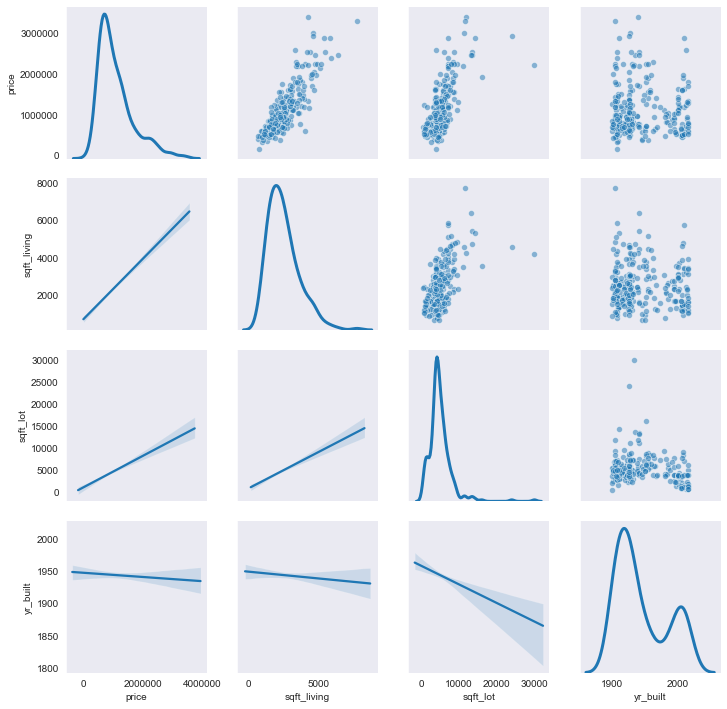

In [116]:
home_info =df_house.loc[:, ('price', 'sqft_living', 'sqft_lot', 'yr_built')]
sns.set_style(style='dark')
g = sns.PairGrid(home_info, diag_sharey=False)
g.map_upper(sns.scatterplot, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)
plt.show()

we plot again by **[df_house['price']>df_house['price'].std()*3**

In [117]:
drop = df_house.loc[df_house['price']>df_house['price'].std()*3].index
df_house = df_house.drop(index=drop)
df_house.shape

(234, 18)

In [118]:
lot_drop = df_house.loc[df_house['sqft_lot']>df_house['sqft_lot'].quantile(.75)].index
raw_data = df_house.drop(index=lot_drop)

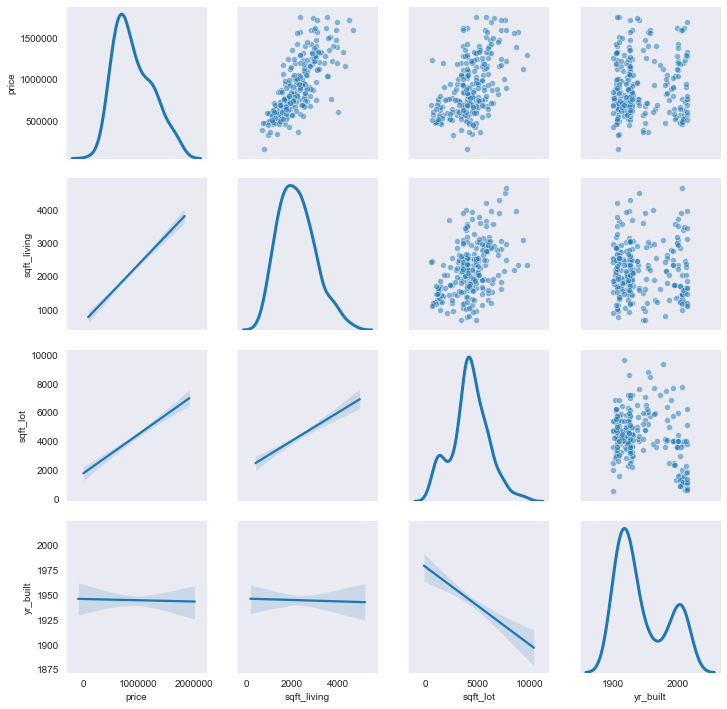

In [119]:
home_info = df_house.loc[:, ('price', 'sqft_living', 'sqft_lot', 'yr_built')]
sns.set_style(style='dark')
g = sns.PairGrid(home_info, diag_sharey=False)
g.map_upper(sns.scatterplot, alpha=.5)
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))
g.map_diag(sns.kdeplot, lw=3)
plt.show()

plots about the **relationship bewteen features( 'floors','bedrooms', 'bathrooms', 'view', 'condition') and 'price' in boxenplot**.

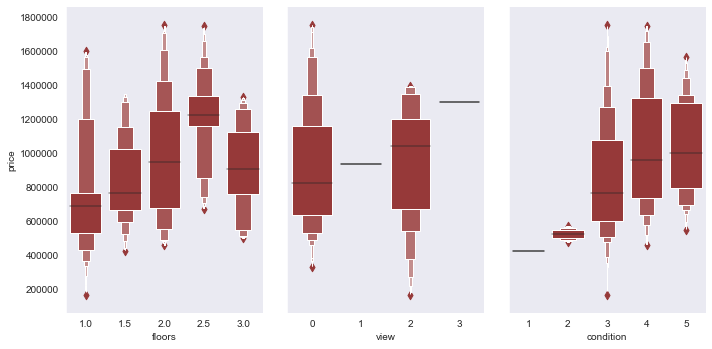

In [120]:
cat = df_house.loc[:, ['price', 'floors','bedrooms', 'bathrooms', 'view', 'condition']]

g = sns.PairGrid(cat, y_vars=['price'], x_vars=['floors', 'view', 'condition'], height=5, aspect=.65)
g = g.map(sns.boxenplot, color='brown')

plt.show()

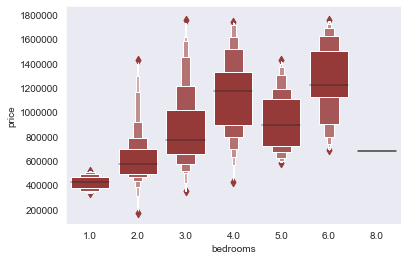

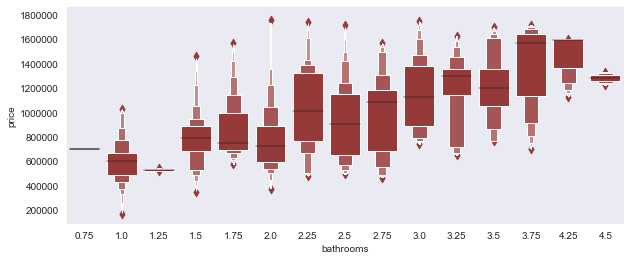

In [121]:
sns.boxenplot(df_house['bedrooms'], y=df_house['price'], color='brown')
plt.show()
plt.figure(figsize=(10,4))
sns.boxenplot(df_house['bathrooms'], y=df_house['price'], color='brown', width=.8)
plt.show()

### Data Preparation

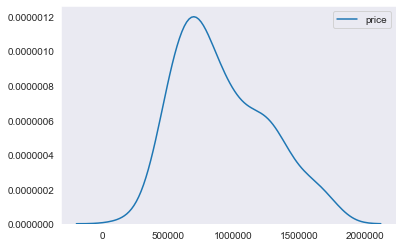

In [122]:
sns.kdeplot(df_house['price'])

In [123]:
df_house['zipcode'] =df_house['zipcode'].astype('object')

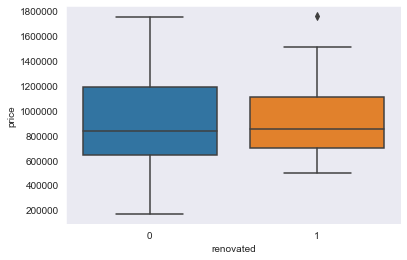

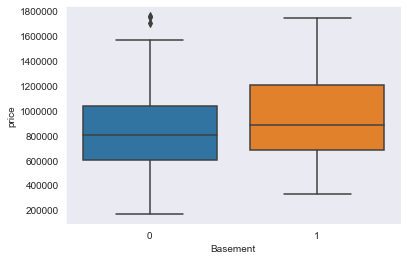

In [124]:
df_house['renovated'] = np.where(df_house['yr_renovated']>0, 1, 0)
sns.boxplot(x='renovated', y='price', data=df_house)
plt.show()
df_house['Basement'] = np.where(df_house['sqft_basement']>0, 1, 0)
sns.boxplot(x='Basement', y='price', data=df_house)
plt.show()

Looks like a few pockets of low restaurant density closest to city center can be found **south, south-east and east from Alexanderplatz**. 

Let's create another heatmap map showing **heatmap/density of Italian restaurants** only.

In [125]:
#Remove redundant variables and make a pointer for dummy variables for zipcode
dummies = pd.get_dummies(df_house['zipcode'])
df_house.drop(['sqft_living15', 'sqft_lot15', 'yr_renovated', 'sqft_above', 'sqft_basement', 'yr_built', 'lat', 'long',
               'zipcode'], 1, inplace=True)

In [126]:
X = df_house.drop('price', 1)
Y = df_house['price']
#make dummies for the zipcode
X_dummy = pd.concat([X, dummies], axis=1)
#Dropping some features that are no longer needed"
colnames = X_dummy.columns

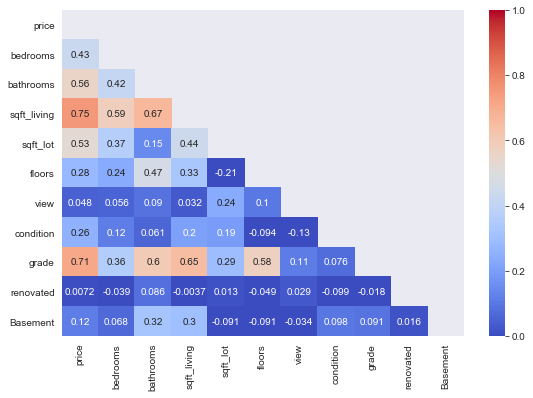

In [127]:
corrmat = df_house.corr()
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(9,6))
sns.heatmap(df_house.corr(), vmin=0, vmax=1, annot=True, mask=mask, cmap='coolwarm')
# sqft_living has the highest correlation w price, so we can use that for the simple linear regression

In [128]:
print("Correlations of features against Price")
display(raw_data.corr().iloc[:, 0].sort_values(ascending=False))
raw_data.columns
#sqft a good candidate for a simple linear regression

Correlations of features against Price


price            1.000000
sqft_above       0.732953
sqft_living      0.732024
grade            0.656946
sqft_living15    0.556505
bathrooms        0.540216
bedrooms         0.427490
sqft_lot15       0.387457
lat              0.344264
floors           0.338709
sqft_lot         0.318715
sqft_basement    0.250948
condition        0.211682
long             0.129260
yr_renovated     0.066402
yr_built         0.046563
view            -0.119391
zipcode               NaN
Name: price, dtype: float64

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built',
       'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')

#### PCA for colinear features

In [129]:
from sklearn.preprocessing import StandardScaler
df_pca = X.loc[:, ['sqft_living', 'grade', 'bedrooms', 'bathrooms', 'floors']]
scalar = StandardScaler(with_mean=True, with_std=True)
scalar = scalar.fit_transform(df_pca)

In [130]:
from sklearn.decomposition import PCA
pca = PCA(n_components=1)
principal_comp = pca.fit_transform(scalar)

df_components = pd.DataFrame(principal_comp, index=X.index, columns=['Living Quality'])

In [131]:
X_ = pd.concat([df_components, X], 1)
X_dummy_pca = pd.concat([df_components, X_dummy], 1)
X_.drop(['sqft_living', 'grade', 'bedrooms', 'bathrooms', 'floors'], axis=1, inplace=True)
X_dummy_pca.drop(['sqft_living', 'grade', 'bedrooms', 'bathrooms', 'floors'], axis=1, inplace=True)

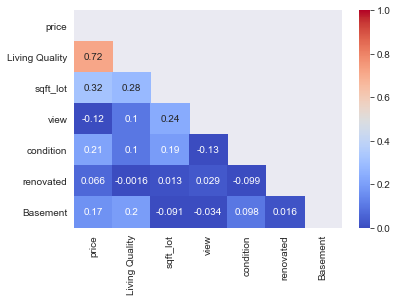

In [132]:
X_pca = pd.concat([raw_data['price'], X_], 1)
corrmat = X_pca.corr()
mask = np.zeros_like(corrmat)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(X_pca.corr(), vmin=0, vmax=1, mask=mask, annot=True, cmap='coolwarm')

### Center predictor variables so we can have a more robust linear model

In [133]:
scalar = StandardScaler(with_mean=True, with_std=True)
scaled = scalar.fit_transform(X) #for lasso and the basic regression on non-PCA features
scaled_df = pd.DataFrame(scaled, index=X.index, columns=X.columns)

X_scaled = pd.concat([scaled_df, dummies], 1) #final dataframe that we will use
#standardize features so that any extreme values in features are accounted for and coefficients are more interpretable

In [134]:
print('Original features scaled:')
display(X_scaled.head())

Original features scaled:


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,condition,grade,renovated,Basement,98112
27,-0.359231,-1.499025,-1.014500,-1.513300,-0.527129,-0.237743,2.135945,-0.190709,-0.361158,-1.348806,1
260,-0.359231,-1.499025,-0.687247,0.079204,-0.527129,-0.237743,-0.633092,-0.190709,-0.361158,0.741397,1
305,-0.359231,-0.561132,-0.359994,-0.542206,-1.490785,-0.237743,0.751427,-0.190709,-0.361158,0.741397,1
495,-1.325440,0.376760,-1.228473,-1.620634,0.436528,-0.237743,-0.633092,-0.190709,-0.361158,0.741397,1
754,-0.359231,-0.561132,-1.052260,-0.231501,-1.490785,-0.237743,2.135945,-1.140196,2.768875,0.741397,1


#### Simple Linear Regression


In [135]:
# First, we make a dataframe to hold the results of our evaluations
evaluation = pd.DataFrame(index=np.arange(0,4),
                          columns=['Model', 'Mean Absolute Error (MAE)', 'CrossVal Score (avg)', 'CrossVal variance'])


In [136]:
from sklearn.linear_model import LinearRegression
simple_X = df_house.loc[:, 'sqft_living'].values.reshape(-1,1)
X_train, X_test, Y_train, Y_test = train_test_split(simple_X, Y, test_size=.2, random_state=10)
lr = LinearRegression(fit_intercept=True)
#Using the sqft_living as the feature as it correlates the most with price
lr.fit(X_train, Y_train)

pearson_test = lr.score(X_test, Y_test)
print("\n20% holdout test score: \n", pearson_test)
print('\nIntercept:')
print(lr.intercept_)
print('\nCoefficients:')
print(lr.coef_)
mae = format(metrics.mean_absolute_error(Y_test, lr.predict(X_test)), '.3f')


20% holdout test score: 
 0.3048855342814135

Intercept:
169059.24130541517

Coefficients:
[330.53393678]


In [137]:
simple_cross = cross_val_score(lr, simple_X, Y, cv=10)
simple_cross

array([0.62659165, 0.64490037, 0.50691942, 0.52224148, 0.46067546,
       0.5124634 , 0.69146794, 0.05488113, 0.53559564, 0.87791755])

In [138]:
evaluation.iloc[0] = ['Simple Linear Model', mae, simple_cross.mean(), simple_cross.std()]
evaluation

,Model,Mean Absolute Error (MAE),CrossVal Score (avg),CrossVal variance
0,Simple Linear Model,210970.861,0.543365,0.199835
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN


#### Use all features

In [139]:
X_train, X_test, Y_train, Y_test = train_test_split(X_dummy, Y, test_size=.2, random_state=123)
full_lr = LinearRegression(fit_intercept=True) #We normalized the data, so no intercept needed
full_lr.fit(X_train, Y_train)

print("20% sample test score: ", full_lr.score(X_test, Y_test))
print("\nIntercept: ", full_lr.intercept_)
print("\nCoefficients: ", full_lr.coef_)
mae = format(metrics.mean_absolute_error(Y_test, full_lr.predict(X_test)), '.3f')
print("\nMean Absolute Error: ", mae)
#multicollinearity can explain why some of these coefficients are negative

20% sample test score:  0.5696096102389976

Intercept:  -756304.3165082515

Coefficients:  [ 4.98755904e+03  3.77423312e+03  1.96483436e+02  3.18329107e+01
 -2.73934344e+04 -2.96274205e+04  4.30370910e+04  1.24055056e+05
  3.23474557e+04 -4.79358648e+04  0.00000000e+00]

Mean Absolute Error:  171711.148


In [140]:
multi_cross = cross_val_score(full_lr, X_dummy, Y, cv=10)
multi_cross

array([0.77108827, 0.77529907, 0.44412283, 0.69505068, 0.51118829,
       0.70824685, 0.62576252, 0.5237275 , 0.70305706, 0.9133484 ])

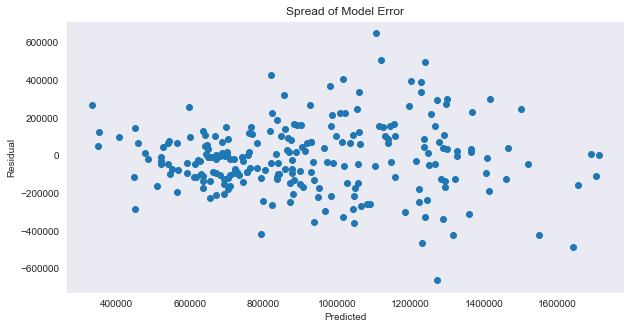

In [141]:
predicted = full_lr.predict(X_dummy)
residual = Y - predicted
plt.figure(figsize=(10,5))
plt.scatter(predicted, residual)
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Spread of Model Error")
#plt.ylim([-5,10])
plt.show()
#Error distribution is not even, so a better model is needed

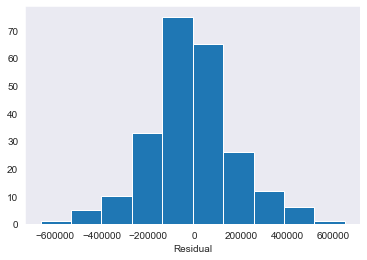

In [142]:
plt.hist(residual)
plt.xlabel("Residual")
plt.show()

In [143]:
evaluation.iloc[1] = ['Multivariable Regression (non-PCA)', mae, multi_cross.mean(), multi_cross.std()]
evaluation

,Model,Mean Absolute Error (MAE),CrossVal Score (avg),CrossVal variance
0,Simple Linear Model,210970.861,0.543365,0.199835
1,Multivariable Regression (non-PCA),171711.148,0.667089,0.135358
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN


#### Multiple Variable Regression with PCA

In [144]:
X_train, X_test, Y_train, Y_test = train_test_split(X_dummy_pca, Y, test_size=.2, random_state=10)
comp_lr = LinearRegression(fit_intercept=True)
comp_lr.fit(X_train, Y_train)
pearson_test = comp_lr.score(X_test, Y_test)
print("20% sample test score: ", pearson_test)
print("\nIntercept: ", comp_lr.intercept_)
print("\nCoefficients: ", comp_lr.coef_)
mae = format(metrics.mean_absolute_error(Y_test, comp_lr.predict(X_test)), '.3f')
print("\nMean Squared Error: ", mae)
X_train.columns

20% sample test score:  0.47840630417571295

Intercept:  408243.4835132467

Coefficients:  [ 1.28247710e+05  6.07332953e+01 -7.76140688e+04  6.66607779e+04
  3.25415681e+04  1.49607827e+04  0.00000000e+00]

Mean Squared Error:  194007.743


Index(['Living Quality',       'sqft_lot',           'view',      'condition',
            'renovated',       'Basement',            98112],
      dtype='object')

In [145]:
pca_cross = cross_val_score(comp_lr, X_dummy_pca, Y, cv=10)
pca_cross

array([0.7263563 , 0.70239036, 0.24593792, 0.62957439, 0.4453903 ,
       0.71238053, 0.61992123, 0.48227726, 0.68781616, 0.87463912])

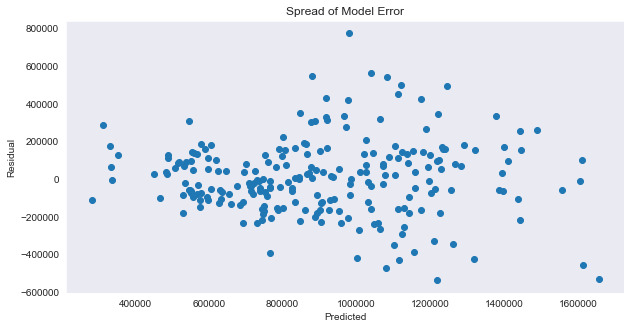

In [146]:
predicted = comp_lr.predict(X_dummy_pca)
residual = Y - predicted
plt.figure(figsize=(10,5))
plt.scatter(predicted, residual)
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Spread of Model Error")

plt.show()

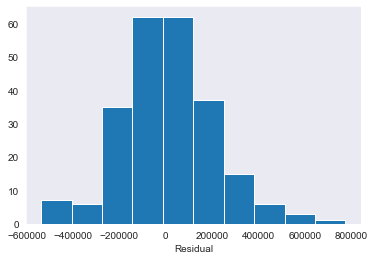

In [147]:
plt.hist(residual)
plt.xlabel("Residual")
plt.show()

In [148]:
evaluation.iloc[2] = ['Multivariable Regression (PCA feats)', mae, pca_cross.mean(), pca_cross.std()]
evaluation

,Model,Mean Absolute Error (MAE),CrossVal Score (avg),CrossVal variance
0,Simple Linear Model,210970.861,0.543365,0.199835
1,Multivariable Regression (non-PCA),171711.148,0.667089,0.135358
2,Multivariable Regression (PCA feats),194007.743,0.612668,0.168821
3,NaN,NaN,NaN,NaN


#### Lasso Regression

In [149]:
from sklearn.linear_model import Lasso
#Lets try to do lasso without the pca to see if we can get some interpretability
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=.2, random_state=10)
lasso = Lasso(alpha=.0001, fit_intercept=False, random_state=123, max_iter=5000, tol=.0001)
#try different lambdas
lasso.fit(X_train, Y_train)
print(X_scaled.columns)
print("\n20% sample score: ", lasso.score(X_test, Y_test))
print("\nCoefficients: ", lasso.coef_)

mae = format(metrics.mean_absolute_error(Y_test, lasso.predict(X_test)), '.3f')
print("\nMean Absolute Error: ", mae)
#convert into scientific notation for better interpretability

Index([   'bedrooms',   'bathrooms', 'sqft_living',    'sqft_lot',
            'floors',        'view',   'condition',       'grade',
         'renovated',    'Basement',         98112],
      dtype='object')

20% sample score:  0.5193377857540366

Coefficients:  [-14804.97985744  31130.53698107 143123.13172069  70600.37735599
  -1819.53843617 -31387.44479325  44437.85604865 117384.44351563
   8965.62548806 -16505.22066708 899495.92358674]

Mean Absolute Error:  193053.918


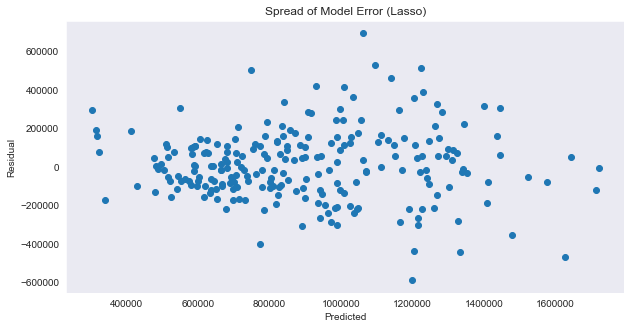

In [150]:
predicted = lasso.predict(X_scaled)
residual = Y - predicted
plt.figure(figsize=(10,5))
plt.scatter(predicted, residual)
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Spread of Model Error (Lasso)")
plt.show()
#Error distribution is not even, so a better model is needed

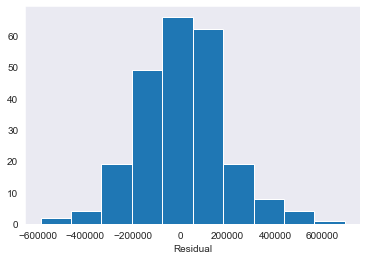

In [151]:
plt.hist(residual)
plt.xlabel("Residual")
plt.show()

In [152]:
lass_cross = cross_val_score(lasso, X_scaled, Y, cv=10)
lass_cross

array([0.77108827, 0.77529907, 0.44412283, 0.69505068, 0.51118829,
       0.70824685, 0.62576252, 0.5237275 , 0.70305706, 0.9133484 ])

In [153]:
evaluation.iloc[3] = ['Lasso', mae, lass_cross.mean(), lass_cross.std()]
evaluation

,Model,Mean Absolute Error (MAE),CrossVal Score (avg),CrossVal variance
0,Simple Linear Model,210970.861,0.543365,0.199835
1,Multivariable Regression (non-PCA),171711.148,0.667089,0.135358
2,Multivariable Regression (PCA feats),194007.743,0.612668,0.168821
3,Lasso,193053.918,0.667089,0.135358


### Final evaluation of model choice

In [154]:
evaluation.iloc[np.argsort(evaluation['CrossVal Score (avg)'])].reset_index(drop=True)

,Model,Mean Absolute Error (MAE),CrossVal Score (avg),CrossVal variance
0,Simple Linear Model,210970.861,0.543365,0.199835
1,Multivariable Regression (PCA feats),194007.743,0.612668,0.168821
2,Multivariable Regression (non-PCA),171711.148,0.667089,0.135358
3,Lasso,193053.918,0.667089,0.135358


## Results and Discussion <a name="results"></a>

Our analysis shows that how a settler to chose a place and he should pay how much for a new house in Seattle . Highest concentration of area was detected Madison Park, so we focused our attention to areas north, north-east and east, corresponding to neighborhood Madison Park. Magnolia was identified as potentially interesting (north-west from Madison Park), but our attention was focused on Madison Park which is an upscale residential community with a number of restaurants and eateries.

After directing our attention to this more narrow area of interest ; those locations were then filtered so that those with less than one schools in radius of 1km and those with at least two park 2km were removed.

From the house price predict models. The Multivariable Regression (non-PCA)	seems quite efficient. Proportionate increase in living quality('bedrooms','bathrooms','floors','grade','sqft') lead to increase in price more linearly. Model seems to be better at estimating prices rather than predicting them.  

Specific property types not included, only sales from one year, so estimations do not account for inflation.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to to find an optimal area for a new comer to settle down in Seattle Specifically, this report will be targeted to the settlers with their family. Also we weill simply estimate the house price in the proper area to give the settlers some idea to find a house. By calculating crime records and some public facilitie, and then generated a proper exact area to statisfy.

Final decission on predicting the house price will be made by previous local sales data based on specific characteristics of neighborhoods and locations, taking into consideration additional factors like having waterfront each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.